In [ ]:
#export
from local.imports import *
from local.test import *
from local.core import *
from local.layers import *
from local.data.all import *
from local.optimizer import *
from local.learner import *
from local.metrics import *
from local.callback.all import *
from local.vision.all import *

# Imagenette

> Integration test

In [ ]:
source = untar_data(URLs.IMAGENETTE_160)
items = get_image_files(source)
split_idx = RandomSplitter()(items)

In [ ]:
ds_img_tfms = [PILFlip(0.5), RandomResizedCrop(128, min_scale=0.35)]
tfms = [PILImage.create, [parent_label, Categorize()]]

In [ ]:
dsrc = DataSource(items, tfms, filts=split_idx, ds_tfms=ds_img_tfms)

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
imagenet_stats = broadcast_vec(1, 4, *imagenet_stats)

In [ ]:
tfms = [Cuda(), ByteToFloatTensor(), Normalize(*imagenet_stats)]
dbch = dsrc.databunch(tfms, bs=64, num_workers=8)

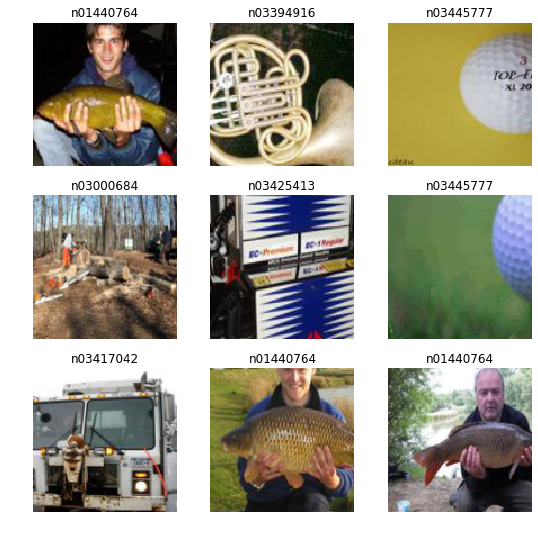

In [ ]:
_,axs = plt.subplots(3,3, figsize=(9,9))
dbch.show_batch(ctxs=axs.flatten())

## Learner

In [ ]:
def cnn_learner(arch, data, loss_func, opt_func, c_in=None, c_out=None,
                lr=1e-2, progress=True, mixup=0, xtra_cb=None, **kwargs):
    cbfs = [MixedPrecision]
    #if mixup:    cbfs.append(partial(MixUp, mixup))
    arch_args = {}
    if not c_in : c_in  = data.c_in
    if not c_out: c_out = data.c_out
    if c_in:  arch_args['c_in' ]=c_in
    if c_out: arch_args['c_out']=c_out
    return Learner(arch(**arch_args), data, loss_func, opt_func=opt_func, lr=lr, cb_funcs=cbfs, **kwargs)

In [ ]:
opt_func = partial(Adam, wd=0.01, eps=1e-3)

In [ ]:
class LabelSmoothingCrossEntropy(Module):
    def __init__(self, eps:float=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction  
    
    def forward(self, output, target):
        c = output.size()[-1]  
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)

In [ ]:
learn = cnn_learner(xresnet18, dbch, LabelSmoothingCrossEntropy(), opt_func=opt_func, c_in=3, c_out=10, lr=1e-2, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.815661,1.650893,0.538088,00:19
1,1.461308,1.417222,0.622853,00:19
2,1.220806,1.157107,0.734877,00:19
3,1.063322,1.010953,0.793503,00:16
4,0.939338,0.936565,0.832338,00:18


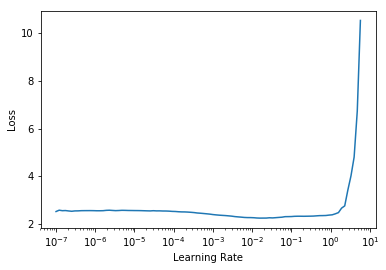

In [ ]:
learn.lr_find()

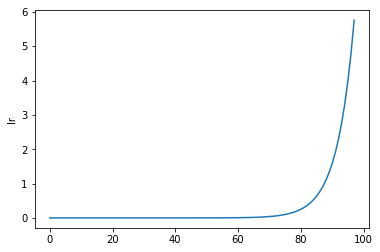

In [ ]:
learn.recorder.plot_sched()

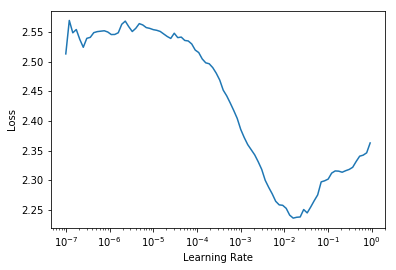

In [ ]:
learn.recorder.plot_lr_find(skip_end=10);

In [ ]:
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.751788,1.716571,0.472367,00:24
